In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from typing import Optional, Dict, List, Union, Tuple
import warnings
warnings.filterwarnings('ignore')

In [2]:
class DataLoader:
    """Handle data loading and initial validation."""
    
    def __init__(self, file_path: str):
        self.file_path = file_path
        self.df = None
        
    def load_data(self) -> Tuple[bool, Optional[pd.DataFrame], Optional[str]]:
        """
        Load data from file with error handling.
        Returns: (success_flag, dataframe, error_message)
        """
        try:
            if self.file_path.endswith('.csv'):
                self.df = pd.read_csv(self.file_path)
            elif self.file_path.endswith(('.xls', '.xlsx')):
                self.df = pd.read_excel(self.file_path)
            else:
                return False, None, "Unsupported file format"
            
            if self.df.empty:
                return False, None, "Empty dataset"
                
            return True, self.df, None
            
        except Exception as e:
            return False, None, str(e)

In [3]:
class DataTypeProfiling:
    """Handle column type identification and validation."""
    
    @staticmethod
    def identify_column_types(df: pd.DataFrame) -> Dict[str, List[str]]:
        """
        Identify and categorize column types.
        Returns dictionary with column types and their corresponding column names.
        """
        try:
            numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
            categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
            datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
            
            return {
                'numeric': numeric_cols,
                'categorical': categorical_cols,
                'datetime': datetime_cols
            }
        except Exception as e:
            raise ValueError(f"Error in column type identification: {str(e)}")

In [5]:
class MissingValueHandler:
    """Handle missing value analysis and imputation."""

    @staticmethod
    def analyze_missing_values(df: pd.DataFrame) -> pd.DataFrame:
        """Analyze missing values and return detailed statistics."""
        missing_stats = pd.DataFrame(
            {
                "missing_count": df.isnull().sum(),
                "missing_percentage": (df.isnull().sum() / len(df)) * 100,
                "dtype": df.dtypes,
            }
        )
        return missing_stats

    @staticmethod
    def impute_missing_values(
        df: pd.DataFrame,
        numeric_strategy: str = "median",
        categorical_strategy: str = "most_frequent",
        custom_values: Dict = None,
    ) -> pd.DataFrame:
        """
        Impute missing values with flexible strategies.

        Parameters:
        - numeric_strategy: 'mean', 'median', 'most_frequent', or 'constant'
        - categorical_strategy: 'most_frequent', 'constant'
        - custom_values: dict of column:value pairs for custom imputation
        """
        df_copy = df.copy()
        col_types = DataTypeProfiling.identify_column_types(df_copy)

        if custom_values:
            for col, value in custom_values.items():
                df_copy[col].fillna(value, inplace=True)

        numeric_imputer = SimpleImputer(strategy=numeric_strategy)
        categorical_imputer = SimpleImputer(strategy=categorical_strategy)

        if col_types["numeric"]:
            df_copy[col_types["numeric"]] = numeric_imputer.fit_transform(
                df_copy[col_types["numeric"]]
            )

        if col_types["categorical"]:
            df_copy[col_types["categorical"]] = categorical_imputer.fit_transform(
                df_copy[col_types["categorical"]]
            )

        return df_copy

In [6]:
class OutlierHandler:
    """Handle outlier detection and treatment."""
    
    @staticmethod
    def detect_outliers(
        df: pd.DataFrame,
        columns: List[str],
        method: str = 'iqr',
        threshold: float = 1.5
    ) -> Dict[str, pd.Series]:
        """
        Detect outliers using multiple methods.
        
        Parameters:
        - method: 'iqr' or 'zscore'
        - threshold: threshold for outlier detection
        """
        outliers = {}
        
        for column in columns:
            if method == 'iqr':
                Q1 = df[column].quantile(0.25)
                Q3 = df[column].quantile(0.75)
                IQR = Q3 - Q1
                outliers[column] = df[
                    (df[column] < Q1 - threshold * IQR) |
                    (df[column] > Q3 + threshold * IQR)
                ][column]
            
            elif method == 'zscore':
                z_scores = np.abs(stats.zscore(df[column]))
                outliers[column] = df[column][z_scores > threshold]
        
        return outliers
    
    @staticmethod
    def handle_outliers(
        df: pd.DataFrame,
        columns: List[str],
        method: str = 'clip',
        threshold: float = 1.5
    ) -> pd.DataFrame:
        """
        Handle outliers using various methods.
        
        Parameters:
        - method: 'clip', 'remove', or 'winsorize'
        """
        df_copy = df.copy()
        
        for column in columns:
            if method == 'clip':
                Q1 = df_copy[column].quantile(0.25)
                Q3 = df_copy[column].quantile(0.75)
                IQR = Q3 - Q1
                df_copy[column] = df_copy[column].clip(
                    lower=Q1 - threshold * IQR,
                    upper=Q3 + threshold * IQR
                )
            elif method == 'winsorize':
                df_copy[column] = stats.mstats.winsorize(df_copy[column], limits=[0.05, 0.05])
            elif method == 'remove':
                outliers = OutlierHandler.detect_outliers(df_copy, [column], threshold=threshold)
                df_copy = df_copy[~df_copy[column].isin(outliers[column])]
                
        return df_copy

In [7]:
class FeatureEncoder:
    """Handle feature encoding for categorical variables."""
    
    @staticmethod
    def encode_categorical_features(
        df: pd.DataFrame,
        columns: List[str],
        method: str = 'onehot',
        max_categories: int = 10
    ) -> pd.DataFrame:
        """
        Encode categorical features using various methods.
        
        Parameters:
        - method: 'onehot', 'label', or 'ordinal'
        - max_categories: maximum number of categories for one-hot encoding
        """
        df_copy = df.copy()
        
        for column in columns:
            if method == 'onehot':
                if df_copy[column].nunique() <= max_categories:
                    dummies = pd.get_dummies(df_copy[column], prefix=column)
                    df_copy = pd.concat([df_copy, dummies], axis=1)
                    df_copy.drop(column, axis=1, inplace=True)
                else:
                    print(f"Warning: {column} has too many categories for one-hot encoding")
            
            elif method == 'label':
                le = LabelEncoder()
                df_copy[f"{column}_encoded"] = le.fit_transform(df_copy[column])
                
            elif method == 'ordinal':
                df_copy[f"{column}_encoded"] = pd.Categorical(df_copy[column]).codes
                
        return df_copy

In [8]:
class FeatureScaler:
    """Handle feature scaling for numeric variables."""
    
    @staticmethod
    def scale_features(
        df: pd.DataFrame,
        columns: List[str],
        method: str = 'standard',
        custom_range: Tuple[float, float] = None
    ) -> pd.DataFrame:
        """
        Scale features using various methods.
        
        Parameters:
        - method: 'standard', 'minmax', or 'robust'
        - custom_range: tuple of (min, max) for MinMaxScaler
        """
        df_copy = df.copy()
        
        if method == 'standard':
            scaler = StandardScaler()
        elif method == 'minmax':
            scaler = MinMaxScaler(feature_range=custom_range if custom_range else (0, 1))
        elif method == 'robust':
            scaler = RobustScaler()
            
        df_copy[columns] = scaler.fit_transform(df_copy[columns])
        return df_copy

In [9]:
class DataVisualizer:
    """Handle data visualization."""
    
    @staticmethod
    def plot_distributions(
        df: pd.DataFrame,
        columns: List[str],
        plot_type: str = 'auto',
        max_categories: int = 10
    ):
        """Plot distributions with automatic plot type selection."""
        for column in columns:
            if df[column].dtype in ['int64', 'float64']:
                plt.figure(figsize=(10, 4))
                
                # Histogram with KDE
                plt.subplot(1, 2, 1)
                sns.histplot(df[column], kde=True)
                plt.title(f'Distribution of {column}')
                
                # Box plot
                plt.subplot(1, 2, 2)
                sns.boxplot(y=df[column])
                plt.title(f'Box Plot of {column}')
                
                plt.tight_layout()
                plt.show()
                
            elif df[column].dtype == 'object':
                if df[column].nunique() <= max_categories:
                    plt.figure(figsize=(10, 4))
                    sns.countplot(data=df, y=column)
                    plt.title(f'Distribution of {column}')
                    plt.tight_layout()
                    plt.show()
                else:
                    print(f"Warning: {column} has too many categories for visualization")

In [10]:
class AdvancedEDA:
    """Main class to orchestrate the EDA process."""
    
    def __init__(self, file_path: str):
        self.file_path = file_path
        self.df = None
        self.column_types = None
        
    def run_complete_eda(
        self,
        missing_strategy: str = 'median',
        encoding_method: str = 'onehot',
        scaling_method: str = 'standard',
        handle_outliers: bool = True
    ) -> Optional[pd.DataFrame]:
        """
        Run complete EDA process with customizable parameters.
        Returns processed DataFrame if successful.
        """
        # Load data
        loader = DataLoader(self.file_path)
        success, df, error = loader.load_data()
        if not success:
            print(f"Error loading data: {error}")
            return None
        
        self.df = df
        
        # Identify column types
        self.column_types = DataTypeProfiling.identify_column_types(self.df)
        
        # Analyze missing values
        missing_analyzer = MissingValueHandler()
        missing_stats = missing_analyzer.analyze_missing_values(self.df)
        print("\nMissing Value Analysis:")
        print(missing_stats)
        
        # Handle missing values
        self.df = missing_analyzer.impute_missing_values(
            self.df,
            numeric_strategy=missing_strategy
        )
        
        # Handle outliers if requested
        if handle_outliers and self.column_types['numeric']:
            self.df = OutlierHandler.handle_outliers(
                self.df,
                self.column_types['numeric']
            )
        
        # Encode categorical features
        if self.column_types['categorical']:
            self.df = FeatureEncoder.encode_categorical_features(
                self.df,
                self.column_types['categorical'],
                method=encoding_method
            )
        
        # Scale numeric features
        if self.column_types['numeric']:
            self.df = FeatureScaler.scale_features(
                self.df,
                self.column_types['numeric'],
                method=scaling_method
            )
        
        # Visualize distributions
        print("\nGenerating visualizations...")
        DataVisualizer.plot_distributions(self.df, self.df.columns)
        
        return self.df


Missing Value Analysis:
             missing_count  missing_percentage    dtype
survived                 0            0.000000    int64
pclass                   0            0.000000    int64
sex                      0            0.000000   object
age                    177           19.865320  float64
sibsp                    0            0.000000    int64
parch                    0            0.000000    int64
fare                     0            0.000000  float64
embarked                 2            0.224467   object
class                    0            0.000000   object
who                      0            0.000000   object
adult_male               0            0.000000     bool
deck                   688           77.216611   object
embark_town              2            0.224467   object
alive                    0            0.000000   object
alone                    0            0.000000     bool

Generating visualizations...


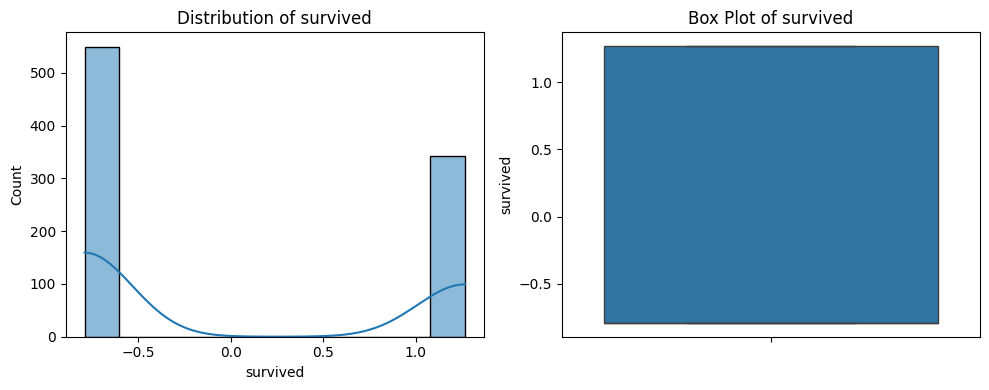

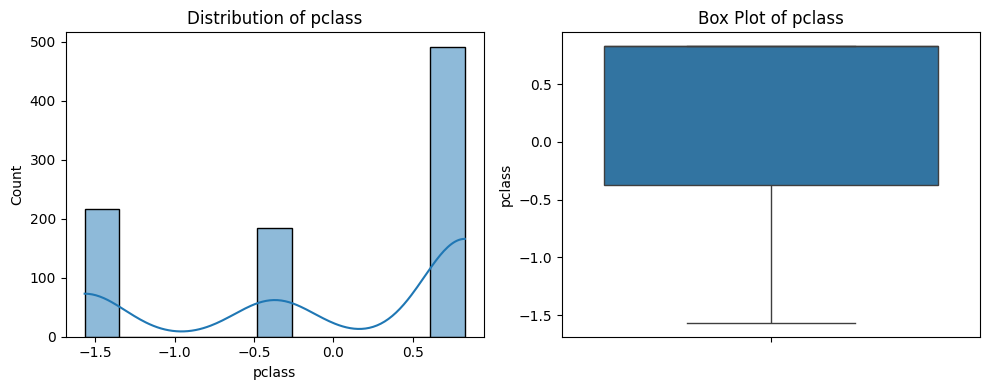

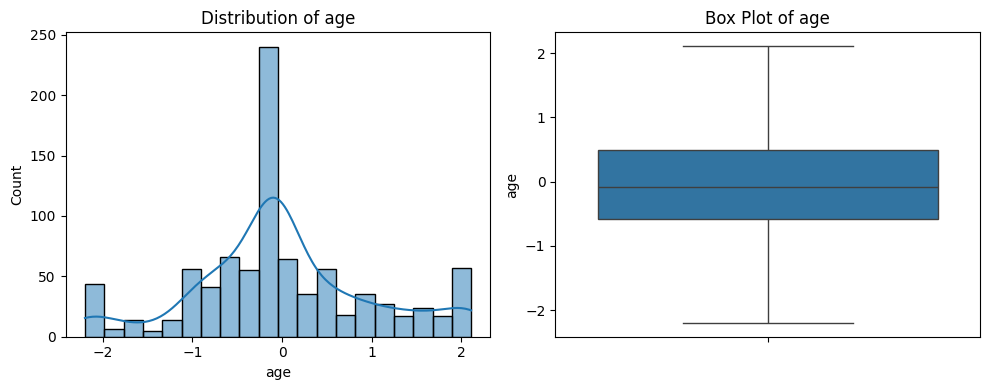

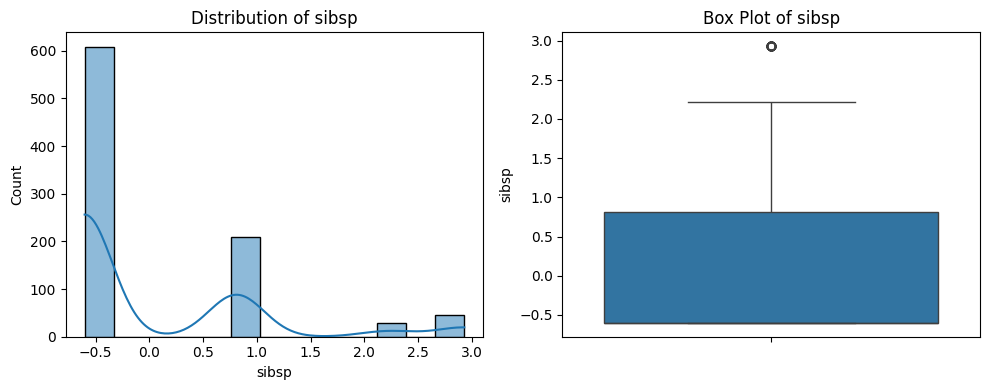

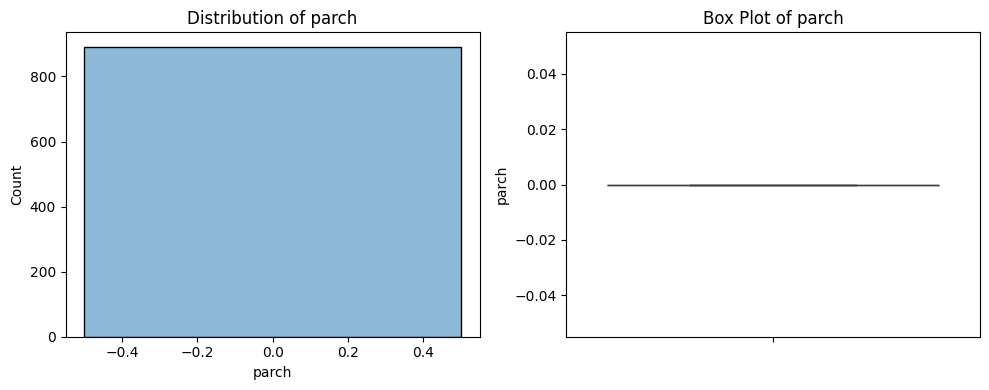

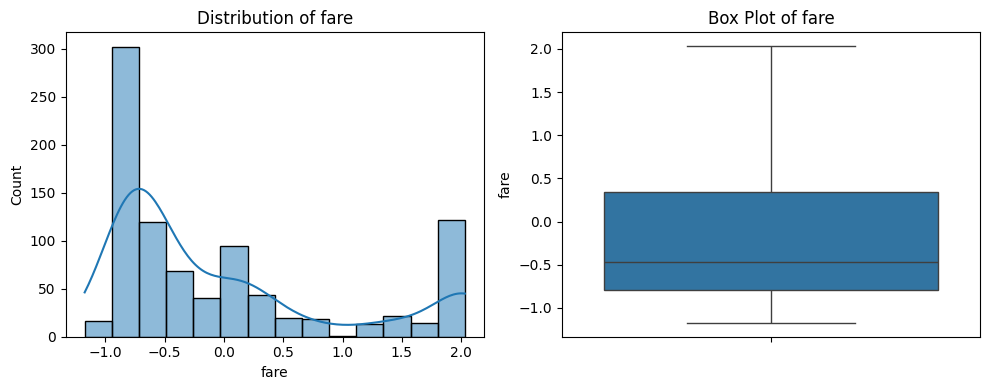

In [11]:
# Example usage:
eda = AdvancedEDA("../dataset/titanic.csv")
processed_df = eda.run_complete_eda(
    missing_strategy="median",
    encoding_method="onehot",
    scaling_method="standard",
    handle_outliers=True,
)

In [12]:
processed_df.isnull().sum()

survived                   0
pclass                     0
age                        0
sibsp                      0
parch                      0
fare                       0
adult_male                 0
alone                      0
sex_female                 0
sex_male                   0
embarked_C                 0
embarked_Q                 0
embarked_S                 0
class_First                0
class_Second               0
class_Third                0
who_child                  0
who_man                    0
who_woman                  0
deck_A                     0
deck_B                     0
deck_C                     0
deck_D                     0
deck_E                     0
deck_F                     0
deck_G                     0
embark_town_Cherbourg      0
embark_town_Queenstown     0
embark_town_Southampton    0
alive_no                   0
alive_yes                  0
dtype: int64

In [ ]:
from DataLoader import DataLoader
loader = DataLoader('../dataset/titanic.csv')
df = loader.load_data()
df.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [ ]:
from Eda import EDAAnalyzer

# Perform EDA
eda = EDAAnalyzer()
eda_report = eda.analyze(df).get_report()
# print("EDA Report:", eda_report)
eda_report['summary_statistics']


,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [23]:
eda_report['missing_values']


,missing_count,missing_percentage
age,177,19.865320
embarked,2,0.224467
deck,688,77.216611
embark_town,2,0.224467


In [25]:
eda_report['data_types']


survived         int64
pclass           int64
sex             object
age            float64
sibsp            int64
parch            int64
fare           float64
embarked        object
class           object
who             object
adult_male        bool
deck            object
embark_town     object
alive           object
alone             bool
dtype: object